[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/VilohitT/llm-thought-tracing/blob/main/notebooks/cultural_knowledge_notebook.ipynb)


# Setup and Dependencies



In [ ]:
# Install required packages
!pip install transformer-lens matplotlib seaborn numpy torch



In [2]:
# Clone the repo
!git clone https://github.com/VilohitT/llm-thought-tracing.git

%cd llm-thought-tracing

Cloning into 'llm-thought-tracing'...
remote: Enumerating objects: 342, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 342 (delta 0), reused 0 (delta 0), pack-reused 341 (from 1)
Receiving objects: 100% (342/342), 31.91 MiB | 20.19 MiB/s, done.
Resolving deltas: 100% (179/179), done.
/content/llm-thought-tracing


In [ ]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import seaborn as sns
from transformer_lens import HookedTransformer
from IPython.display import display, Markdown, HTML
import matplotlib.animation as animation
import warnings

from llm_reasoning_tracer.concept_extraction import extract_concept_activations
from llm_reasoning_tracer.reasoning_analysis import analyze_reasoning_paths
from llm_reasoning_tracer.causal_intervention import perform_causal_intervention
from llm_reasoning_tracer.visualization import (
    plot_concept_activation_heatmap,
    animate_concept_activation_diagonal,
    animate_reasoning_flow,
    animate_reasoning_flow_dark,
    plot_layer_position_intervention,
    save_animation
)

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)


## Load the Model

We'll use the Llama 3.2-3B-Instruct model, which provides a good balance between performance and computational requirements.


In [4]:
from google.colab import userdata
from huggingface_hub import login

hf_key = userdata.get('hf_key')
login(hf_key)

In [ ]:
def load_llama_3_2():
    return HookedTransformer.from_pretrained("meta-llama/Llama-3.2-3B-Instruct", device="cuda")

model = load_llama_3_2()
print(f"Loaded model: {model.cfg.model_name}")
print(f"Number of layers: {model.cfg.n_layers}")
print(f"Number of attention heads: {model.cfg.n_heads}")
print(f"Hidden size: {model.cfg.d_model}")

# Enable attention result caching for detailed analysis
model.cfg.use_attn_result = True



### 🧠 Multi-Hop Knowledge Retrieval: Knight → Batman → Joker → Heath


In [6]:
# Define the prompt and concepts
fact_prompt = "In the Dark Knight movie, the antagonist is played by"

# Define potential intermediate and final concepts
fact_intermediates = [" Knight", " Batman", " Joker"]
fact_finals = [" Heath"]

# Define potential reasoning paths
fact_paths = [
    [" Knight", " Batman", " Joker", " Heath"],  # Complete multi-hop path
    [" Knight", " Joker", " Heath"],             # Partial path (skipping Batman)
    [" Knight", " Heath"]                        # Direct path (skipping intermediates)
]

# Print the prompt and expected reasoning path
display(Markdown(f"**Prompt:** {fact_prompt}"))
display(Markdown(f"**Expected reasoning path:** Knight → Batman → Joker → Heath"))



**Prompt:** In the Dark Knight movie, the antagonist is played by

**Expected reasoning path:** Knight → Batman → Joker → Heath

### 📊 Step 1: Extracting Concept Activations

#### 🎥 Extracting Cultural Concept Traces



In [7]:
# First, let's check if the model gets the correct answer
tokens = model.to_str_tokens(fact_prompt)
logits = model(fact_prompt)
final_pos = len(tokens) - 1

# Get top predictions
probs = torch.softmax(logits[0, final_pos], dim=0)
top_vals, top_indices = torch.topk(probs, k=5)
top_tokens = [model.to_single_str_token(idx.item()) for idx in top_indices]
top_probs = top_vals.cpu().detach().numpy()

# Display top predictions
display(Markdown("### Model's top predictions:"))
for token, prob in zip(top_tokens, top_probs):
    display(Markdown(f"- **{token}**: {prob:.4f}"))

# Extract concept activations
fact_concept_results = extract_concept_activations(
    model,
    fact_prompt,
    intermediate_concepts=fact_intermediates,
    final_concepts=fact_finals,
    logit_threshold=0.05
)



### Model's top predictions:

- ** Heath**: 0.3335

- ** the**: 0.2209

- ** Christian**: 0.0986

- ** a**: 0.0817

- ** actor**: 0.0481

### 🎨 Step 2: Visualizing Concept Evolution Across Layers & Positions


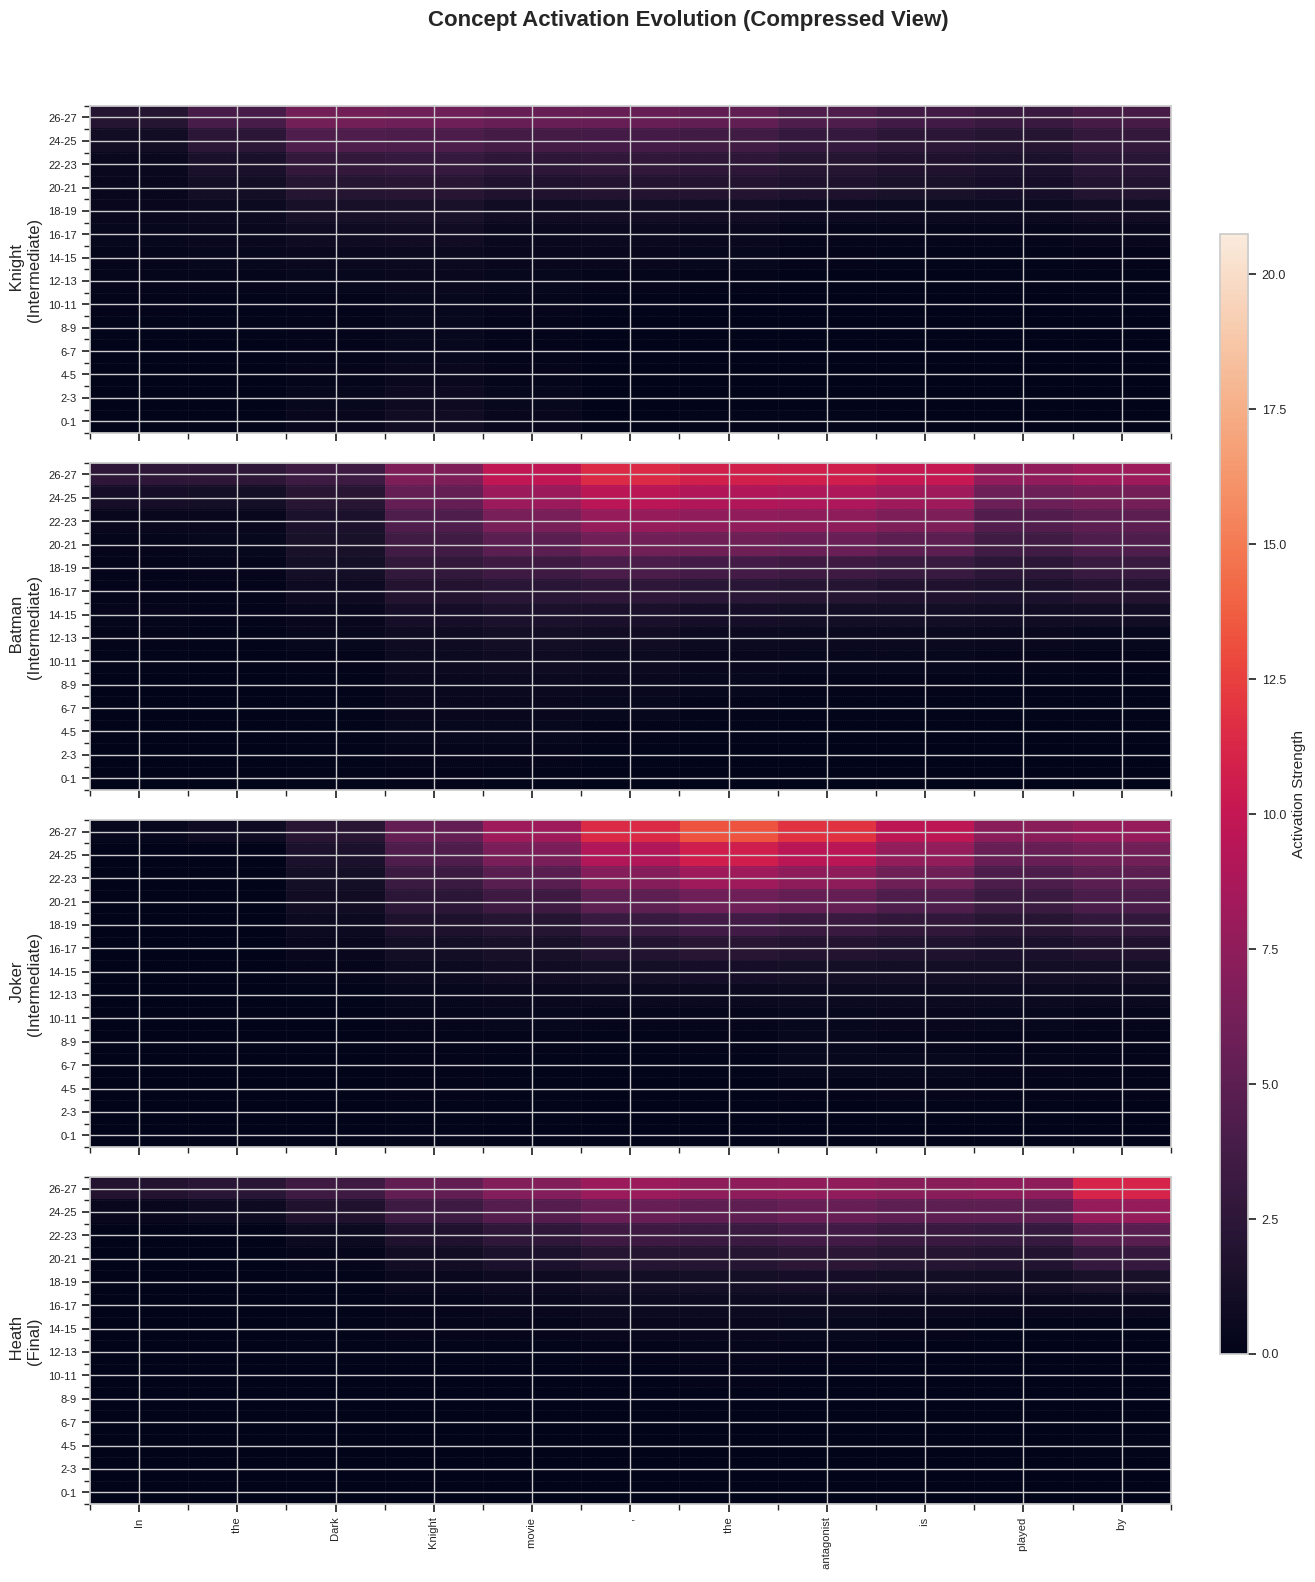

<Figure size 640x480 with 0 Axes>

In [8]:
# Visualize concept evolution
fig12 = plot_concept_activation_heatmap(fact_concept_results)
plt.tight_layout()
fig12.savefig("figures/cultural_concept_evolution.png", dpi=300, bbox_inches='tight')
display(fig12)



In [9]:
# Animate concept activation for Knight
ani = animate_concept_activation_diagonal(fact_concept_results, selected_concepts=[" Knight"])
display(HTML(ani.to_jshtml()))
ani.save("figures/knight_activation_diagonal.gif", writer=PillowWriter(fps=10), dpi=300)

In [10]:
# Animate concept activation for Batman
ani = animate_concept_activation_diagonal(fact_concept_results, selected_concepts=[" Batman"])
display(HTML(ani.to_jshtml()))
ani.save("figures/batman_activation_diagonal.gif", writer=PillowWriter(fps=10), dpi=300)

In [11]:
# Animate concept activation for Joker
ani = animate_concept_activation_diagonal(fact_concept_results, selected_concepts=[" Joker"])
display(HTML(ani.to_jshtml()))
ani.save("figures/joker_activation_diagonal.gif", writer=PillowWriter(fps=10), dpi=300)

In [12]:
# Animate concept activation for Heath
ani = animate_concept_activation_diagonal(fact_concept_results, selected_concepts=[" Heath"])
display(HTML(ani.to_jshtml()))
ani.save("figures/heath_activation_diagonal.gif", writer=PillowWriter(fps=10), dpi=300)

### 🧠 Step 3: Tracing Reasoning Paths Across Layers


In [13]:
# Analyze reasoning paths
fact_path_results = analyze_reasoning_paths(
    model,
    fact_prompt,
    potential_paths=fact_paths,
    concept_threshold=0.05
)

# Print path scores
display(Markdown("### Reasoning Path Scores:"))
for path_data in fact_path_results["path_scores"]:
    path = path_data["path"]
    score = path_data["score"]
    complete = path_data.get("complete", False)
    in_order = path_data.get("in_order", False)

    path_str = " → ".join(path)
    status = ""
    if not complete:
        status = "(Missing concepts)"
    elif not in_order:
        status = "(Out of order)"

    display(Markdown(f"- **{path_str}**: {score:.4f} {status}"))

# Print best path
if fact_path_results["best_path"]:
    best_path = " → ".join(fact_path_results["best_path"])
    display(Markdown(f"**Best path:** {best_path} (score: {fact_path_results['best_path_score']:.4f})"))



### Reasoning Path Scores:

- ** Knight →  Batman →  Joker →  Heath**: 1.0000 

- ** Knight →  Joker →  Heath**: 1.0000 

- ** Knight →  Heath**: 1.0000 

**Best path:**  Knight →  Batman →  Joker →  Heath (score: 1.0000)

### 🎬 Step 4: Visualizing the Full Reasoning Trajectory


In [14]:
# Visualize reasoning path analysis
anim = animate_reasoning_flow(
    fact_path_results,
    tokens=tokens[1:],
    model_layers=model.cfg.n_layers
)
display(HTML(anim.to_jshtml()))



In [15]:
anim = save_animation(
    path_results=fact_path_results,
    tokens=tokens[1:],
    model_layers=model.cfg.n_layers,
    output_path="figures/cultural_flow_knight_dark.gif",
    format="gif",
    fps=1,
    dpi=300
)

Animation saved to figures/cultural_flow_knight_dark.gif


### 🧠 Step 5: Causal Tracing – How Does Corruption Affect the Model's Belief?

In [16]:
# Perform causal intervention on key tokens
fact_intervention_results = perform_causal_intervention(
    model,
    fact_prompt,
    concepts=[" Heath"],
    target_positions=[8]     # "antagonist" replaced with "protagonist"
)

# Print top influential tokens for the final answer
display(Markdown("### Most Influential Tokens for 'Heath':"))
for i, influence in enumerate(fact_intervention_results["token_importance"][" Heath"][:5]):
    display(Markdown(f"- **{influence['token']}** (position {influence['position']}): Effect = {influence['effect']:.4f}"))



### Most Influential Tokens for 'Heath':

- ** antagonist** (position 8): Effect = 3.2279

### 🔬 Visualizing Causal Influence Across Layers and Positions


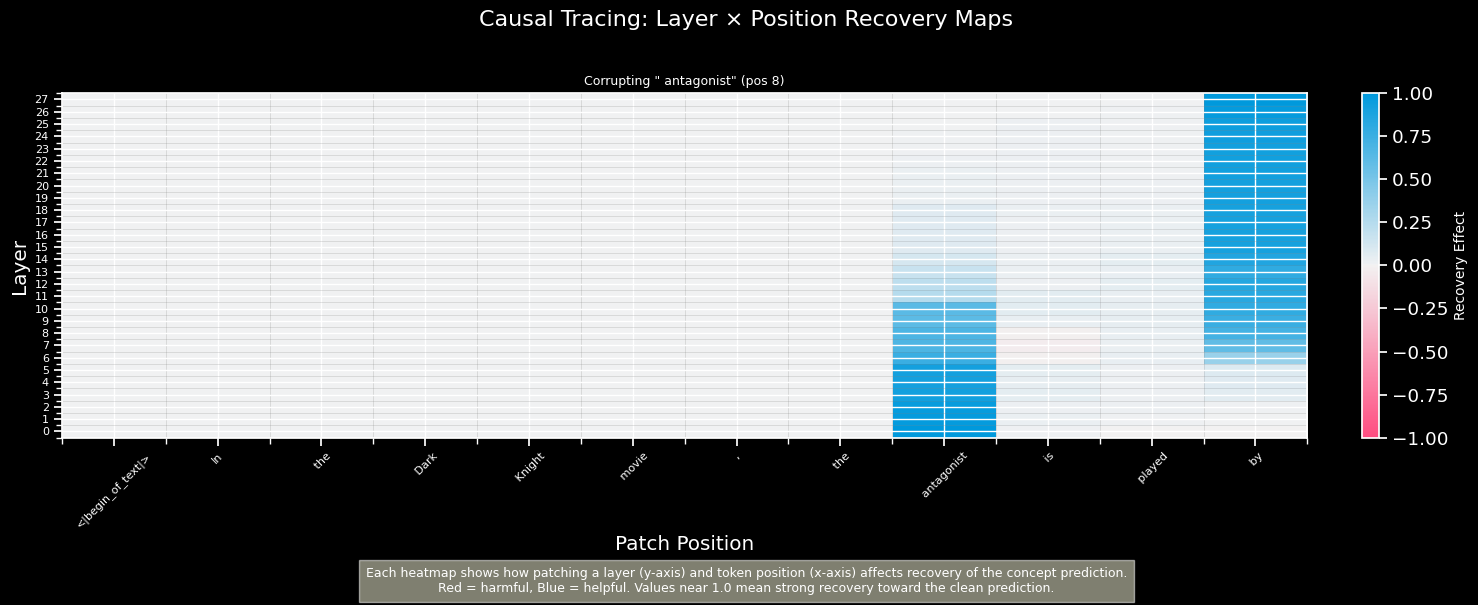

<Figure size 640x480 with 0 Axes>

In [17]:
# Visualize causal intervention
fig13 = plot_layer_position_intervention(fact_intervention_results)
plt.tight_layout()
fig13.savefig("figures/cultural_causal_intervention.png", dpi=300, bbox_inches='tight')
display(fig13)

